In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import qtensor.states as states 
import qtensor.operators as ops
from qtensor.simulation.finiteTDVP import tdvp, right_mpo_contractions, gs_evolve
import qtensor.simulation.finiteTDVP as sim
import qtensor.thermofield as thf 

Basic state

In [2]:
a = np.random.rand(2,3,3) + 1j * np.random.rand(2,3,3)
b = np.random.rand(2,3,3) + 1j * np.random.rand(2,3,3)

psi = states.mps([a, a, b, a, b])
psi.right_canonical()

H = ops.tilted_ising(N=5)

H_spin_up = ops.tilted_ising(J=0, h=1, g=0, N=5)


Ground state evolve

In [3]:
psi = gs_evolve(psi, H_spin_up, 1000, 100)

Intial energy: (0.37872158577600856+4.509107303504073e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-4.999999999902436-4.718447873947026e-16j)


Thermofield stuff

In [4]:
N = 8
D = 8
H_usual = ops.tilted_ising(N=N)
beta = 1
H_th = thf.thermofield_hamiltonian(H_usual)


Intial energy: (0.020503272680248055+9.899102491720557e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-7.9999961905631665+6.562479873685706e-16j)
Initiating TDVP
TDVP finished!
Energy at finite temperature: -7.6974303792802585


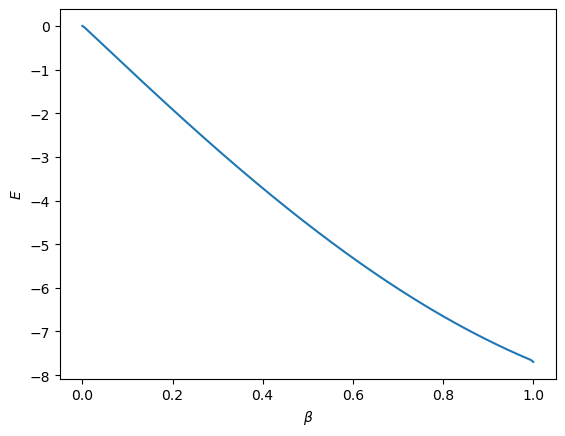

In [5]:
beta_psi, times, energies = thf.finite_T_thermofield(beta, N, D, H_th, steps=200)

In [6]:
# compare this to the groundstate energy
randpsi = states.random_mps(N, 2, D)
gs_evolve(randpsi, H_usual)

Intial energy: (-4.162048062445335-4.426325008087262e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-9.590983998497533+6.52689697496516e-17j)


Testing near thermal ansatz builder

In [7]:
N = 8
D = 10
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)


In [8]:
inf_T_state = sim.inf_T_thermofield_variational(N, D)

Intial energy: (0.193309960189443-1.2802394777980318e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-7.944460059491334-4.366624249685369e-17j)


In [9]:
beta_avg = 0.05
delta_beta = 0.01

# gaussian profile ontop of an average, 
# with temp highest at centre,
# adjusted to have zero mean
d_beta_profile = delta_beta*np.exp(-np.linspace(-N/2, N/2, N)**2) 
d_beta_profile = d_beta_profile - np.mean(d_beta_profile)*np.ones(N)

beta_profile = beta_avg*np.ones(N) - d_beta_profile
 
profile_state = thf.near_thermal(H_tf, beta_profile, D, initial_state=inf_T_state)

Initiating TDVP
TDVP finished!


Initiating TDVP
TDVP finished!
Energy at finite temperature: -0.4910997032947803


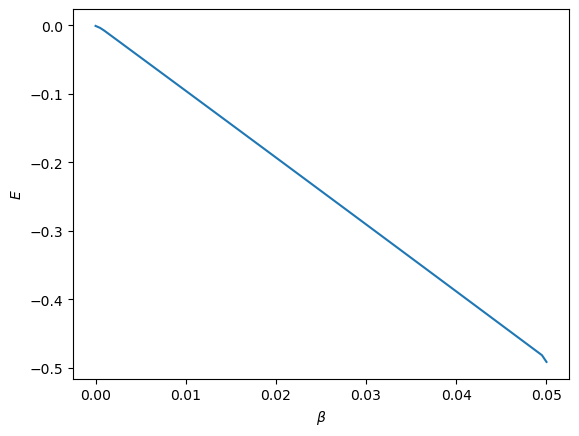

In [10]:
even_state = thf.finite_T_thermofield(beta_avg, N, D, H_tf, initial_state=inf_T_state)[0]

In [11]:
# Checking energy along chain
local_energy = []
even_energy = []
sites = sorted(list(H_usual.sites))
local_ops = ops.extensive_as_terms(H_tf)
for term in local_ops:
    local_energy.append(ops.local_expect(profile_state, term))
    even_energy.append(ops.local_expect(even_state, term))

c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Bond')

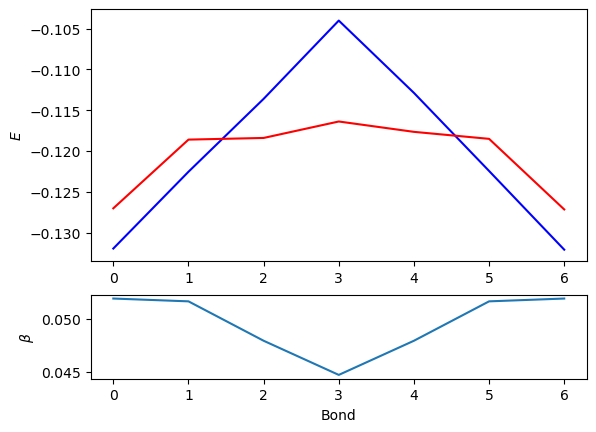

In [12]:
fix, ax = plt.subplots(2, 1, height_ratios=[3, 1])
ax[0,].plot(sites[:-1], local_energy, color='b')
ax[0,].plot(sites[:-1], even_energy, color='r')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")

Do real time evolution on almost-thermal state

In [17]:
initial_state = copy.deepcopy(profile_state)
t_f = 0.1
n_steps = 100
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, sim.method_exact, history=True, operators=[H_tf])


Initiating TDVP
TDVP finished!


c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


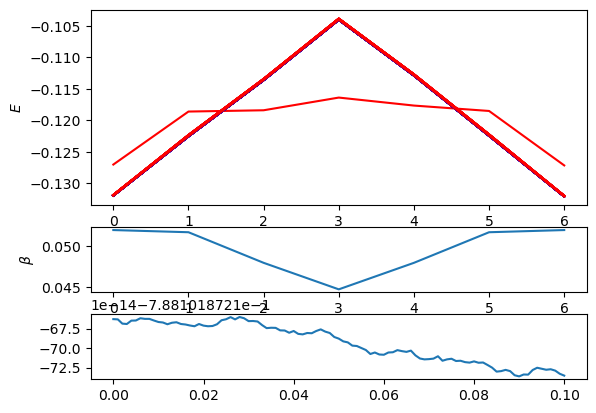

In [18]:
fix, ax = plt.subplots(3, 1, height_ratios=[3, 1, 1])
ax[0,].plot(sites[:-1], local_energy, color='b')
ax[0,].plot(sites[:-1], even_energy, color='r')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")


times = evolved_state.keys()
E_profile={}
for t in times:
    E_profile[t] = [ops.local_expect(evolved_state[t], op) for op in local_ops]
    ax[0,].plot(sites[:-1], E_profile[t], color=(t/t_f, 0, 1-t/t_f))

total_energy = [expectations[t][0] for t in times]
ax[2,].plot(times, total_energy)
